##INTRODUCTION

This project is not set out to recommend any stocks. I'm not a trader, not even close. However, it is my interest to learn more about how to read stock charts and using technical indicators and see how it compare to trade based on speculation and news (of course, these two create volatility offering short term opportunities). I learned many of the code below from Derek Banas, an Udemy instructor. I recommend anyone interested in the same topic NOT to just copy the code. It helps to type out all the code, google/stackoverflow anything you don't understand, and most importantly, google the concept behind ichimoku cloud, moving average, etc.  Once you have a more than a basic understanding of the concept and the code, try to use the code to build your own portfolio and use the ichimoku cloud to test few trades. I only scratched the surface and there are so much more to learn! I will be continuing to learn more, create a Tableau visulization on the EDA, and building up this project 😃.

The data is from yfinance and https://www.nasdaq.com/market-activity/stocks/screener


The code is seperated into 3 parts:

1.  EDA on NYSE and NASDAQ

2.  Downloading Stock Data and Building the Ichimoku Cloud.

3.  Finding a Optimal Portfolio with Sharpe Ratio.



**Sidenote:** Due to the amount of time it required to download all the stocks from NASDAQ, I only picked the top 200 based on market cap. Of course, you can run on all of the NASDAQ tickers if you would like. 

**Import libraries**

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import time
import os
import seaborn as sns

**Obtain Stock Data from Yahoo Finance**

In [2]:
pip install yfinance

     |████████████████████████████████| 6.4 MB 7.8 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
import yfinance as yf

**Set Start and End Date**

In [4]:
# Start end date defaults
S_DATE = "2017-02-01"
E_DATE = "2023-02-01"
S_DATE_DT = pd.to_datetime(S_DATE)
E_DATE_DT = pd.to_datetime(E_DATE)

**Getting the CSV on Some of My Selected Tickers**

In [11]:
tickers = ['AMZN', 'COST', 'ADBE', 'QQQ', 'NVDA', 'VUG', 'VGT', 'VOO', 'SPY', 'ARKK', 'ADBE','NVDA', 'AMD', 'MSFT', 'DIS', 'WMT', 'TGT', 'HD']

for ticker in tickers:
  stock = yf.Ticker(ticker)
  df = stock.history(period="5y")
  df.sort_index(axis = 0.,  ascending=False)
  df.to_csv(ticker + '.csv')


##EDA on NASDAQ and NYSE

The goal of this notebook is to code the ichimoku cloud and finding a optimal portfolio based on cumulative returns. We run a EDA on the dataset, but may not impute or change or fill in some of the missing values. 

Data source: https://www.nasdaq.com/market-activity/stocks/screener

In [14]:
nasdaq = pd.read_csv("/content/Nasdaq.csv")
nasdaq.head(3)

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,AAPL,Apple Inc. Common Stock,$172.79,3.91,2.32%,2.995720e+12,United States,1980.0,62473258,Technology,Computer Manufacturing
1,MSFT,Microsoft Corporation Common Stock,$300.47,5.47,1.85%,2.252580e+12,United States,1986.0,26739593,Technology,Computer Software: Prepackaged Software
2,GOOGL,Alphabet Inc. Class A Common Stock,"$2,732.17",21.65,0.80%,1.805890e+12,United States,NaN,1319869,Technology,Internet and Information Services


In [44]:
nasdaq.shape

(8414, 11)

In [22]:
nasdaq.dtypes

#IPO Year is in float64, most likely due to NaN values. 

Symbol         object
Name           object
Last Sale      object
Net Change    float64
% Change       object
Market Cap    float64
Country        object
IPO Year      float64
Volume          int64
Sector         object
Industry       object
dtype: object

In [34]:
# Missing values

percent_missing = nasdaq.isnull().sum() * 100 / len(nasdaq)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df.sort_values(by=['percent_missing'], ascending=False)

#nasdaq[nasdaq.isna().any(axis=1)]

,percent_missing
IPO Year,40.373188
Sector,26.194438
Industry,26.016164
Country,9.424768
Market Cap,5.585928
% Change,0.071310
Symbol,0.000000
Name,0.000000
Last Sale,0.000000
Net Change,0.000000


In [42]:
# Duplicate values
percentage = nasdaq.duplicated(keep=False).value_counts(normalize=True) * 100
percentage

False    100.0
dtype: float64

In [19]:
nasdaq.describe()

,Net Change,Market Cap,IPO Year,Volume
count,8414.000000,7.944000e+03,5017.000000,8.414000e+03
mean,0.858206,8.048765e+09,2014.940403,1.006303e+06
std,17.360950,6.181095e+10,8.940584,4.450063e+06
min,-86.160000,0.000000e+00,1972.000000,1.000000e+00
25%,0.000000,5.564069e+07,2013.000000,1.488175e+04
50%,0.110000,3.724824e+08,2019.000000,1.103035e+05
75%,0.560000,2.265847e+09,2021.000000,5.547030e+05
max,1570.000000,2.995720e+12,2022.000000,1.795731e+08


In [47]:
nasdaq.columns

Index(['Symbol', 'Name', 'Last Sale', 'Net Change', '% Change', 'Market Cap',
       'Country', 'IPO Year', 'Volume', 'Sector', 'Industry'],
      dtype='object')

In [53]:
#print(nasdaq['Sector'].value_counts())
print(nasdaq['Sector'].value_counts(normalize=True)*100)

Finance                  26.586151
Health Care              18.550725
Technology               13.558776
Consumer Services        12.061192
Capital Goods             7.697262
Consumer Non-Durables     3.768116
Energy                    3.510467
Public Utilities          3.446055
Basic Industries          3.317230
Miscellaneous             3.011272
Consumer Durables         2.560386
Transportation            1.932367
Name: Sector, dtype: float64


Rows, Columns: (8414, 11)


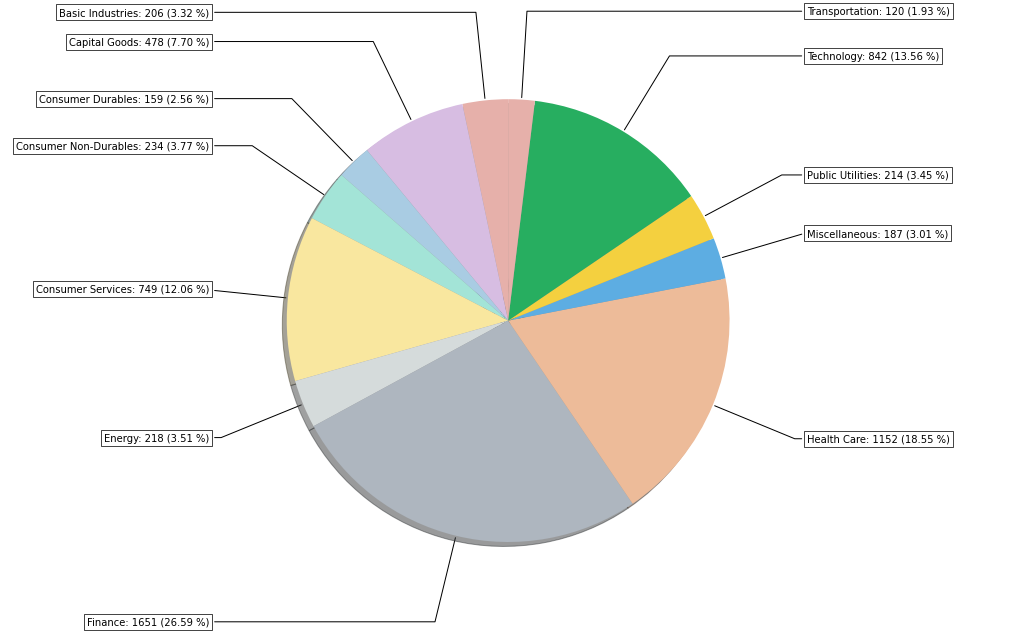

In [62]:
print("Rows, Columns:",nasdaq.shape)
Sector = nasdaq.groupby('Sector').size()
labels = Sector.index.values
sizes = Sector.values
muestra = []
for k in range(0,labels.size):
  texto = labels[k]+': '+str(sizes[k])+' ({:,.2f} %)'.format((100*sizes[k]/sum(sizes)))
  muestra.append(texto)
colors = ['#E6B0AA','#D7BDE2','#A9CCE3','#A3E4D7','#F9E79F','#D5DBDB','#AEB6BF','#EDBB99','#5DADE2','#F4D03F','#27AE60']
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props, zorder=0, va="center")
fig,ax1 = plt.subplots(figsize=(18,9),ncols=1,nrows=1)
wedges, texts = ax1.pie(sizes, shadow=True, colors=colors, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax1.annotate(muestra[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
plt.show()

In [90]:
nasdaq['Industry'].groupby(nasdaq['Sector']).value_counts()


Sector                 Industry                                                      
Basic Industries       Major Chemicals                                                    32
                       Precious Metals                                                    31
                       Steel/Iron Ore                                                     28
                       Industrial Specialties                                             27
                       Agricultural Chemicals                                             12
                       Paper                                                              12
                       Metal Fabrications                                                 11
                       Specialty Chemicals                                                 7
                       Water Sewer Pipeline Comm & Power Line Construction                 7
                       Paints/Coatings                                       

In [121]:
country = nasdaq['Country'].value_counts()
country[0:21] 

United States     6308
China              230
Canada             228
Israel             118
United Kingdom      99
Bermuda             70
Cayman Islands      62
Hong Kong           49
Greece              34
Brazil              32
Switzerland         30
Netherlands         28
Singapore           27
Germany             24
Mexico              23
Ireland             22
France              17
Australia           16
Argentina           16
Luxembourg          15
Malaysia            12
Name: Country, dtype: int64

In [15]:
nyse = pd.read_csv("/content/NYSE.csv")
nyse.head(3)

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,A,Agilent Technologies Inc. Common Stock,$135.91,0.70,0.518%,4.082276e+10,United States,1999.0,2368248,Capital Goods,Electrical Products
1,AA,Alcoa Corporation Common Stock,$74.04,0.18,0.244%,1.363075e+10,NaN,2016.0,6819279,Basic Industries,Metal Fabrications
2,AAC,Ares Acquisition Corporation Class A Ordinary ...,$9.75,0.01,0.103%,1.218750e+09,NaN,2021.0,88047,Finance,Business Services


In [123]:
nyse.shape

(3183, 11)

In [125]:
# Missing values

percent_missing = nyse.isnull().sum() * 100 / len(nyse)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df.sort_values(by=['percent_missing'], ascending=False)

#nasdaq[nasdaq.isna().any(axis=1)]

,percent_missing
IPO Year,46.685517
Sector,26.453032
Industry,26.264530
Country,22.965756
Market Cap,14.043355
Symbol,0.000000
Name,0.000000
Last Sale,0.000000
Net Change,0.000000
% Change,0.000000


In [126]:
nyse.describe()

,Net Change,Market Cap,IPO Year,Volume
count,3183.000000,2.736000e+03,1697.000000,3.183000e+03
mean,1.273917,1.327673e+10,2012.660577,1.377164e+06
std,27.965390,4.004989e+10,9.131653,4.984651e+06
min,-31.990000,0.000000e+00,1986.000000,1.000000e+00
25%,0.002800,4.018503e+08,2007.000000,3.711650e+04
50%,0.180000,1.755592e+09,2016.000000,2.349100e+05
75%,0.775000,7.984638e+09,2020.000000,9.886290e+05
max,1570.000000,6.457607e+11,2022.000000,1.811841e+08


In [127]:
#print(nyse['Sector'].value_counts())
print(nyse['Sector'].value_counts(normalize=True)*100)

Finance                  30.499786
Consumer Services        16.275096
Technology                9.611277
Capital Goods             9.568560
Public Utilities          6.236651
Energy                    5.980350
Basic Industries          5.425032
Health Care               5.168731
Consumer Non-Durables     4.186245
Miscellaneous             2.819308
Transportation            2.648441
Consumer Durables         1.580521
Name: Sector, dtype: float64


Rows, Columns: (3183, 11)


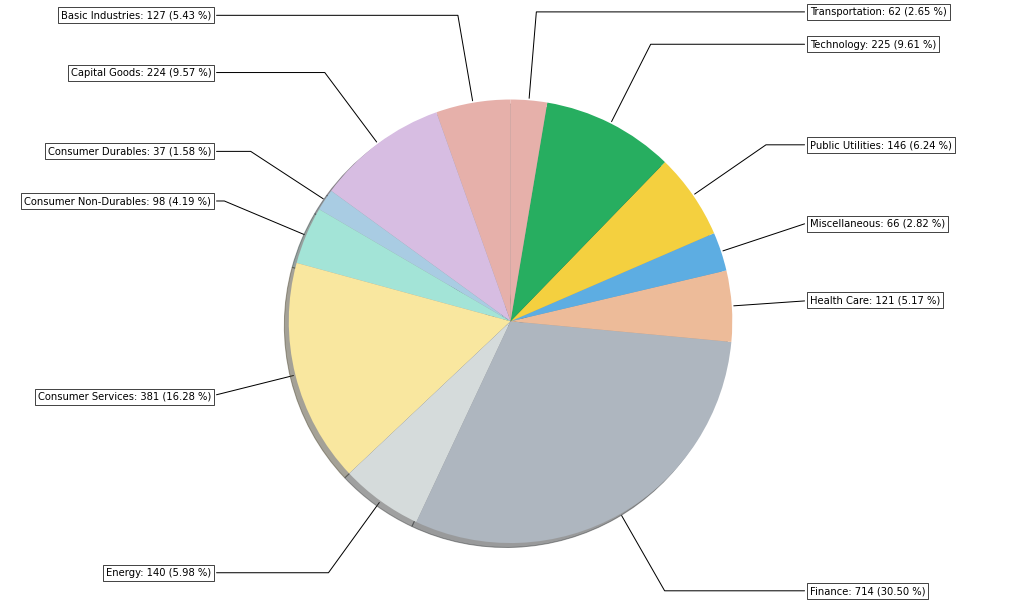

In [128]:
print("Rows, Columns:",nyse.shape)
Sector = nyse.groupby('Sector').size()
labels = Sector.index.values
sizes = Sector.values
muestra = []
for k in range(0,labels.size):
  texto = labels[k]+': '+str(sizes[k])+' ({:,.2f} %)'.format((100*sizes[k]/sum(sizes)))
  muestra.append(texto)
colors = ['#E6B0AA','#D7BDE2','#A9CCE3','#A3E4D7','#F9E79F','#D5DBDB','#AEB6BF','#EDBB99','#5DADE2','#F4D03F','#27AE60']
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props, zorder=0, va="center")
fig,ax1 = plt.subplots(figsize=(18,9),ncols=1,nrows=1)
wedges, texts = ax1.pie(sizes, shadow=True, colors=colors, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax1.annotate(muestra[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
plt.show()

In [129]:
country = nyse['Country'].value_counts()
country[0:21] 

United States     2063
Canada              71
Bermuda             49
China               36
United Kingdom      28
Brazil              20
Greece              16
Switzerland         13
Netherlands         11
Monaco              10
Mexico              10
Argentina           10
Cayman Islands       9
Japan                9
Chile                8
South Korea          8
Ireland              8
India                8
Luxembourg           8
South Africa         6
Singapore            4
Name: Country, dtype: int64

**Downloading the Tickers from NASDAQ.csv**

In [131]:
def get_column_from_csv(file, col_name):
    # Try to get the file and if it doesn't exist issue a warning
    try:
        df = pd.read_csv(file)
    except FileNotFoundError:
        print("File Doesn't Exist")
    else:
        return df[col_name]

In [141]:
tickers = get_column_from_csv("/content/Nasdaq.csv", "Symbol")
print(len(tickers))
tickers

8414


0         AAPL
1         MSFT
2        GOOGL
3         GOOG
4         AMZN
         ...  
8409     WRB^G
8410     WRB^H
8411     WSO/B
8412    XFLT^A
8413    YCBD^A
Name: Symbol, Length: 8414, dtype: object

In [142]:
def save_to_csv_from_yahoo(folder, ticker):
    stock = yf.Ticker(ticker)
    
    try:
        print("Get Data for : ", ticker)
        # Get historical closing price data
        df = stock.history(period="5y")
    
        # Wait 2 seconds
        time.sleep(2)
        
        # Remove the period for saving the file name
        # Save data to a CSV file
        # File to save to 
        the_file = folder + ticker.replace(".", "_") + '.csv'
        print(the_file, " Saved")
        df.to_csv(the_file)
    except Exception as ex:
        print("Couldn't Get Data for :", ticker)

In [143]:
PATH = "/content/"

*Due to the amount of tickers and the run time required for the code. I ran the top 199 tickers only in the NASDAQ base on market cap.*

In [144]:
for x in range(0, 200):
    save_to_csv_from_yahoo(PATH, tickers[x])
    print("Finished")

Get Data for :  AAPL
/content/AAPL.csv  Saved
Finished
Get Data for :  MSFT
/content/MSFT.csv  Saved
Finished
Get Data for :  GOOGL
/content/GOOGL.csv  Saved
Finished
Get Data for :  GOOG
/content/GOOG.csv  Saved
Finished
Get Data for :  AMZN
/content/AMZN.csv  Saved
Finished
Get Data for :  TSLA
/content/TSLA.csv  Saved
Finished
Get Data for :  NVDA
/content/NVDA.csv  Saved
Finished
Get Data for :  TSM
/content/TSM.csv  Saved
Finished
Get Data for :  FB
/content/FB.csv  Saved
Finished
Get Data for :  V
/content/V.csv  Saved
Finished
Get Data for :  JPM
/content/JPM.csv  Saved
Finished
Get Data for :  UNH
/content/UNH.csv  Saved
Finished
Get Data for :  JNJ
/content/JNJ.csv  Saved
Finished
Get Data for :  BAC
/content/BAC.csv  Saved
Finished
Get Data for :  PG
/content/PG.csv  Saved
Finished
Get Data for :  MA
/content/MA.csv  Saved
Finished
Get Data for :  WMT
/content/WMT.csv  Saved
Finished
Get Data for :  HD
/content/HD.csv  Saved
Finished
Get Data for :  BABA
/content/BABA.csv  Sa

In [145]:
def get_stock_df_from_csv(tickers):
  try:
    df = pd.read_csv(PATH + tickers + '.csv', index_col=0)
  except FileNotFoundError:
    print("File Doesn't Exist")
  else:
    return df

In [146]:
get_stock_df_from_csv('COST')

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-02-16,156.497613,157.150055,155.970283,157.078552,2206500,0.0,0
2017-02-17,156.828298,157.748871,155.943470,157.176865,2424400,0.0,0
2017-02-21,157.793539,158.195729,157.301967,158.142105,2317000,0.0,0
2017-02-22,158.258361,158.276226,156.470838,157.757843,1815200,0.0,0
2017-02-23,157.766741,158.231487,156.595916,157.167923,2599900,0.0,0
...,...,...,...,...,...,...,...
2022-02-09,528.000000,534.239990,525.679993,528.830017,2256700,0.0,0
2022-02-10,520.869995,524.469971,514.750000,518.479980,2558900,0.0,0
2022-02-11,518.400024,521.349976,507.380005,509.670013,2348800,0.0,0


In [148]:
from os import listdir
from os.path import isfile, join

files = [x for x in listdir(PATH) if isfile(join(PATH, x))]
tickers = [os.path.splitext(x)[0] for x in files]
len(tickers)

703

In [149]:
def add_daily_return_to_df(df):
  df['daily_return'] = (df['Close'] / df['Close'].shift(1)) - 1
  return df

In [150]:
def add_cum_return_to_df(df):
  df['cum_return'] = (1 + df['daily_return']).cumprod()
  return df

In [151]:
def add_bollinger_bands(df):
  df['middle_band'] = df['Close'].rolling(window=20).mean()
  df['upper_band'] = df['middle_band'] + 1.96 * df['Close'].rolling(window=20).std()
  df['lower_band'] = df['middle_band'] - 1.96 * df['Close'].rolling(window=20).std()
  return df

In [152]:
def add_ichimoku(df):
  #Conversion line
  hi_val = df['High'].rolling(window=9).max()
  lo_val = df['Low'].rolling(window=9).min()
  df['Conversion'] = (hi_val+lo_val)/2

  #Base Line
  hi_val2 = df['High'].rolling(window=26).max()
  lo_val2 = df['Low'].rolling(window=26).min()
  df['Baseline'] = (hi_val2+lo_val2)/2

  #Span A
  df['SpanA'] = ((df['Conversion'] + df['Baseline']) / 2)

  #Span B
  hi_val3 = df['High'].rolling(window=52).max()
  lo_val3 = df['Low'].rolling(window=52).min()
  df['SpanB'] = ((hi_val3 + lo_val3)/2).shift(26)

  #Laggine Span
  df['Lagging'] = df['Close'].shift(-26)
  return df



##What is the Ichimoku Cloud?

Ichimoku is a technical indicator. The 5 lines of the cloud are:

1. Tenkan Sen = Conversion Line: determine the direction of the short-term trend (yellow). Faster line. 
2. Kijun Sen = Base Line: avg for medium point and shows mid-term trend (red). Slower line.
3. Senkou Span A = Leading Span A (green)
4. Senkou Span B = Leading Span B (red)
5. Chikou Line = Lagging Span (teal): helps to confirm signal.


Few important concepts:
1. Formed between Span A and Span B, the **cloud** shows support and resistance.
2. Span A and Span B are set 26 periods into the future.  
3. Chikou represents the closing price and set 26 periods in the past. 
4. Wider the cloud, the stronger the trend. 
5. Try to not use the strategy for less than 1 hour. 


Reading the cloud:
1. Price is above the cloud: UP trend. Green color. Top of cloud is the support. 
2. Price is below the cloud: DOWN trend. Red color. Bottom of cloud is the resistant. 
3. Not recommended to trade when price is inside the cloud. Market is not trending. Use top of cloud as resistance and bottom as support. 
4. Tk/Golden Cross: when conversion past base from bottom to up, a **BUY** signal. If the price is above the cloud during this cross, it is a strong buy signal. If the price is below the cloud, you may want to wait until price is on top of the cloud. If the lagging span is crossing the price at the same time at the same direction, it's also another signal on buy. Set the stop loss at the narest local minimum.
5. Death Cross: when conversion past base from top to bottom, a **SELL** signal. If the price is below the cloud during this cross, it is a strong sell signal. If the price is above the cloud, you may want to wait until price is on bottom of the cloud before entering short positions. Set the stop loss at the narest local maximum.

Strategy Visualization: [ichimoku](https://yukiphotostudio.pixieset.com/ichimoku/)

In [153]:
for x in tickers:
  try:
    print("Working on:", x)
    new_df = get_stock_df_from_csv(x)
    new_df = add_daily_return_to_df(new_df)
    new_df = add_cum_return_to_df(new_df)
    new_df = add_bollinger_bands(new_df)
    new_df = add_ichimoku(new_df)
    new_df.to_csv(PATH + x + '.csv')
  except Exception as ex:
    print(ex)

Working on: BBN
Working on: ASG
Working on: AXTA
Working on: ICE
Working on: EQIX
Working on: CNI
Working on: AJXA
Working on: NVO
Working on: JD
Working on: BRO
Working on: AHT^D
Working on: CMCSA
Working on: AORT
Working on: ATH^B
Working on: ALE
Working on: BVH
Working on: AFB
Working on: ASAN
Working on: AFI
Working on: SHW
Working on: Nasdaq
'Close'
Working on: AAP
Working on: ACII
Working on: UBS
Working on: ACR
Working on: BABA
Working on: AJX
Working on: ABM
Working on: EW
Working on: AMK
Working on: BSX
Working on: AZN
Working on: ABG
Working on: CB
Working on: AXR
Working on: AHL^E
Working on: BPT
Working on: AMR
Working on: BLK
Working on: BMEZ
Working on: BDJ
Working on: ASPN
Working on: BCO
Working on: AX
Working on: BCC
Working on: EL
Working on: AUS
Working on: BSIG
Working on: BLL
Working on: BKNG
Working on: ARLO
Working on: APO
Working on: BLND
Working on: LCID
Working on: CVX
Working on: BUR
Working on: T
Working on: BXSL
Working on: AP
Working on: RTX
Working on: AE

**Testing on Costco stock**

In [154]:
df = pd.read_csv('/content/COST.csv', index_col=0)

#daily return
df['daily_return'] = (df['Close'] / df['Close'].shift(1)) - 1

#cumulative return
df['cum_return'] = (1 + df['daily_return']).cumprod()

#moving average 20 days
df['middle_band'] = df['Close'].rolling(window=20).mean()
df['upper_band'] = df['middle_band'] + 1.96 * df['Close'].rolling(window=20).std()
df['lower_band'] = df['middle_band'] - 1.96 * df['Close'].rolling(window=20).std()

#Conversion line
hi_val = df['High'].rolling(window=9).max()
lo_val = df['Low'].rolling(window=9).min()
df['Conversion'] = (hi_val+lo_val)/2

#Base Line
hi_val2 = df['High'].rolling(window=26).max()
lo_val2 = df['Low'].rolling(window=26).min()
df['Baseline'] = (hi_val2+lo_val2)/2

#Span A
df['SpanA'] = ((df['Conversion'] + df['Baseline']) / 2)

#Span B
hi_val3 = df['High'].rolling(window=52).max()
lo_val3 = df['Low'].rolling(window=52).min()
df['SpanB'] = ((hi_val3 + lo_val3)/2).shift(26)

#Laggine Span
df['Lagging'] = df['Close'].shift(-26)

#return df
df


,Open,High,Low,Close,Volume,Dividends,Stock Splits,daily_return,cum_return,middle_band,upper_band,lower_band,Conversion,Baseline,SpanA,SpanB,Lagging
Date,,,,,,,,,,,,,,,,,
2017-02-16,156.497613,157.150055,155.970283,157.078552,2206500,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,148.498428
2017-02-17,156.828298,157.748871,155.943470,157.176865,2424400,0.0,0,0.000626,1.000626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.052628
2017-02-21,157.793539,158.195729,157.301967,158.142105,2317000,0.0,0,0.006141,1.006771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.642441
2017-02-22,158.258361,158.276226,156.470838,157.757843,1815200,0.0,0,-0.002430,1.004325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150.053589
2017-02-23,157.766741,158.231487,156.595916,157.167923,2599900,0.0,0,-0.003739,1.000569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.874863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-09,528.000000,534.239990,525.679993,528.830017,2256700,0.0,0,0.014737,3.366660,502.233392,537.233897,467.232888,504.709881,518.079768,511.394824,518.501300,NaN
2022-02-10,520.869995,524.469971,514.750000,518.479980,2558900,0.0,0,-0.019572,3.300769,501.907178,536.158241,467.656114,512.063752,516.247559,514.155656,519.119345,NaN
2022-02-11,518.400024,521.349976,507.380005,509.670013,2348800,0.0,0,-0.016992,3.244682,501.585789,535.411614,467.759965,515.213971,510.491300,512.852636,523.849531,NaN


In [179]:
def plot_with_boll_bands(df, ticker):
  fig = go.Figure()

  candle = go.Candlestick(x=df.index, open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name='Candlestick')

  upper_line = go.Scatter(x=df.index, y=df['upper_band'], 
                          line=dict(color='rgba(250,0,0,0.75)',
                          width=1), name='Upper Band')

  mid_line = go.Scatter(x=df.index, y=df['middle_band'], 
                          line=dict(color='rgba(0,0,250,0.75)',
                          width=1), name='Middle Band')
  
  lower_line = go.Scatter(x=df.index, y=df['lower_band'], 
                          line=dict(color='rgba(0,25,0,0.75)',
                          width=1), name='Lower Band')
  
  fig.add_trace(candle)
  fig.add_trace(upper_line)
  fig.add_trace(mid_line)
  fig.add_trace(lower_line)

  fig.update_xaxes(title='Date', rangeslider_visible=True)
  fig.update_yaxes(title='Price')

  fig.update_layout(title="Bollinger Bands", height=1200, width=1800, showlegend=True)

  fig.show()

In [185]:
import plotly.graph_objs as go

fig = go.Figure()

candle = go.Candlestick(x=df.index, open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name='Candlestick')

upper_line = go.Scatter(x=df.index, y=df['upper_band'], 
                          line=dict(color='rgba(250,0,0,0.75)',
                          width=1), name='Upper Band')

mid_line = go.Scatter(x=df.index, y=df['middle_band'], 
                          line=dict(color='rgba(0,0,250,0.75)',
                          width=1), name='Middle Band')
  
lower_line = go.Scatter(x=df.index, y=df['lower_band'], 
                          line=dict(color='rgba(0,25,0,0.75)',
                          width=1), name='Lower Band')
  
fig.add_trace(candle)
fig.add_trace(upper_line)
fig.add_trace(mid_line)
fig.add_trace(lower_line)

fig.update_xaxes(title='Date', rangeslider_visible=True)
fig.update_yaxes(title='Price')

fig.update_layout(title="Bollinger Bands", height=800, width=1200, showlegend=True)

#fig.show()

In [171]:
def get_fill_color(label):
    if label >= 1:
        return 'rgba(0,250,0,0.2)'
    else:
        return 'rgba(250,0,0,0.2)'

In [183]:
def get_ichimoku(df):
  candle = go.Candlestick(x=df.index, open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name='Candlestick')

  df1 = df.copy()
  fig = go.Figure()
  df['label'] = np.where(df['SpanA'] > df['SpanB'], 1, 0) #return 1 for green, return 0 for red
  df['group'] = df['label'].ne(df['label'].shift()).cumsum()
  df = df.groupby('group')

  dfs = []
  for name, data in df:
    dfs.append(data)
  for df in dfs:
    fig.add_traces(go.Scatter(x=df.index, y=df.SpanA,
        line=dict(color='rgba(0,0,0,0)')))

    fig.add_traces(go.Scatter(x=df.index, y=df.SpanB,
        line=dict(color='rgba(0,0,0,0)'),
        fill='tonexty',
        fillcolor=get_fill_color(df['label'].iloc[0])))
    
  baseline = go.Scatter(x=df1.index, y=df1['Baseline'],
                        line=dict(color='red', width=3), name='Baseline')
  
  conversion = go.Scatter(x=df1.index, y=df1['Conversion'],
                          line=dict(color='gold', width=3), name='Conversion')
  
  lagging = go.Scatter(x=df1.index, y=df1['Lagging'],
                          line=dict(color='purple', width=2), name='Lagging')
  
  span_a = go.Scatter(x=df1.index, y=df1['SpanA'],
                          line=dict(color='green', width=2, dash='dot'), name='Span A')
  
  span_b = go.Scatter(x=df1.index, y=df1['SpanB'],
                          line=dict(color='red', width=2, dash='dot'), name='Span B')
  
  fig.add_trace(candle)
  fig.add_trace(baseline)
  fig.add_trace(conversion)
  fig.add_trace(lagging)
  fig.add_trace(span_a)
  fig.add_trace(span_b)

  fig.update_layout(height=800, width=1200, showlegend=True)

  fig.show()



In [184]:
costco = get_stock_df_from_csv('COST')
get_ichimoku(costco)

##Optimal Portfolio

In [186]:
#sec_df = pd.read_csv('/content/big_stock_sectors.csv')
sec_df = pd.read_csv('/content/Nasdaq.csv')

In [189]:
sec_df.rename(columns={'Symbol': 'Ticker'}, inplace=True)


In [191]:
sec_df.head()

,Ticker,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,AAPL,Apple Inc. Common Stock,$172.79,3.91,2.32%,3.000000e+12,United States,1980.0,62473258,Technology,Computer Manufacturing
1,MSFT,Microsoft Corporation Common Stock,$300.47,5.47,1.85%,2.250000e+12,United States,1986.0,26739593,Technology,Computer Software: Prepackaged Software
2,GOOGL,Alphabet Inc. Class A Common Stock,"$2,732.17",21.65,0.80%,1.810000e+12,United States,NaN,1319869,Technology,Internet and Information Services
3,GOOG,Alphabet Inc. Class C Capital Stock,"$2,728.51",22.51,0.83%,1.800000e+12,United States,2004.0,1313677,Technology,Internet and Information Services
4,AMZN,Amazon.com Inc. Common Stock,"$3,130.21",26.87,0.87%,1.590000e+12,United States,1997.0,2815676,Consumer Services,Catalog/Specialty Distribution


In [190]:
sec_df['Sector'].value_counts()

Finance                  1651
Health Care              1152
Technology                842
Consumer Services         749
Capital Goods             478
Consumer Non-Durables     234
Energy                    218
Public Utilities          214
Basic Industries          206
Miscellaneous             187
Consumer Durables         159
Transportation            120
Name: Sector, dtype: int64

In [202]:
finance_df = sec_df.loc[sec_df['Sector'] == "Finance"]
health_df = sec_df.loc[sec_df['Sector'] == "Health Care"]
tech_df = sec_df.loc[sec_df['Sector'] == "Technology"]
consumer_df = sec_df.loc[sec_df['Sector'] == "Consumer Services"]
goods_df = sec_df.loc[sec_df['Sector'] == "Capital Goods"]
nondurables_df = sec_df.loc[sec_df['Sector'] == "Consumer Non-Durables"]
energy_df = sec_df.loc[sec_df['Sector'] == "Energy"]
public_utilities_df = sec_df.loc[sec_df['Sector'] == "Public Utilities"]
industries_df = sec_df.loc[sec_df['Sector'] == "Basic Industries"]
misc_df = sec_df.loc[sec_df['Sector'] == "Miscellaneous"]
durables_df = sec_df.loc[sec_df['Sector'] == "Consumer Durables"]
transportation_df = sec_df.loc[sec_df['Sector'] == "Transportation"]


In [204]:
tech_df

,Ticker,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,AAPL,Apple Inc. Common Stock,$172.79,3.9100,2.32%,3.000000e+12,United States,1980.0,62473258,Technology,Computer Manufacturing
1,MSFT,Microsoft Corporation Common Stock,$300.47,5.4700,1.85%,2.250000e+12,United States,1986.0,26739593,Technology,Computer Software: Prepackaged Software
2,GOOGL,Alphabet Inc. Class A Common Stock,"$2,732.17",21.6500,0.80%,1.810000e+12,United States,NaN,1319869,Technology,Internet and Information Services
3,GOOG,Alphabet Inc. Class C Capital Stock,"$2,728.51",22.5100,0.83%,1.800000e+12,United States,2004.0,1313677,Technology,Internet and Information Services
6,NVDA,NVIDIA Corporation Common Stock,$264.95,22.2800,9.18%,6.620000e+11,United States,1999.0,69539716,Technology,Semiconductors
...,...,...,...,...,...,...,...,...,...,...,...
7780,STRNW,Stran & Company Inc. Warrant,$0.37,0.0112,3.11%,0.000000e+00,United States,2021.0,36192,Technology,Advertising
7782,SURGW,SurgePays Inc. Warrant,$0.70,-0.0499,-6.65%,0.000000e+00,United States,NaN,7595,Technology,Computer Software: Prepackaged Software
7844,TRKAW,Troika Media Group Inc. Warrant,$0.26,0.0199,8.29%,0.000000e+00,United States,2021.0,12045,Technology,Advertising
7876,VENAW,Venus Acquisition Corporation Warrant,$0.11,-0.0357,-24.50%,0.000000e+00,United States,2021.0,2618,Technology,EDP Services


In [205]:
def get_cum_ret_for_stocks(stock_df):
    tickers = []
    cum_rets = []

    for index, row in stock_df.iterrows():
        df = get_stock_df_from_csv(row['Ticker'])
        if df is None:
            pass
        else:
            tickers.append(row['Ticker'])
            cum = df['cum_return'].iloc[-1]
            cum_rets.append(cum)
    return pd.DataFrame({'Ticker':tickers, 'CUM_RET':cum_rets})

In [206]:
finance_df = get_cum_ret_for_stocks(finance_df)
health_df = get_cum_ret_for_stocks(health_df)
tech_df = get_cum_ret_for_stocks(tech_df)
consumer_df = get_cum_ret_for_stocks(consumer_df)
goods_df = get_cum_ret_for_stocks(goods_df)
nondurables_df = get_cum_ret_for_stocks(nondurables_df)
energy_df = get_cum_ret_for_stocks(energy_df)
public_utilities_df = get_cum_ret_for_stocks(public_utilities_df)
industries_df = get_cum_ret_for_stocks(industries_df)
misc_df = get_cum_ret_for_stocks(misc_df)
durables_df = get_cum_ret_for_stocks(durables_df)
transportation_df = get_cum_ret_for_stocks(transportation_df)


Streaming output truncated to the last 5000 lines.
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist
File Doesn't Exist

In [224]:
print('Finance:')
print(finance_df .sort_values(by=['CUM_RET'], ascending=False).head(10))



Finance:
   Ticker   CUM_RET
12     BX  5.307576
43   ARES  4.905030
34    APO  3.936637
25    PGR  3.230007
72    BST  3.204402
40    BRO  3.189560
55     AB  3.117242
38    AJG  3.039912
20    IBN  2.725014
36    AMP  2.685283


In [225]:
print('Health:')
print(health_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

Health:
   Ticker   CUM_RET
28   MRNA  8.124731
33   BHVN  8.040000
20    ZTS  3.862215
25     EW  3.700545
18   ISRG  3.609007
4     LLY  3.384756
9     DHR  3.273928
5     NVO  3.176873
0     UNH  3.151293
6     ABT  3.055688


In [226]:
print(tech_df.sort_values(by=['CUM_RET'], ascending=False).head(10))
print(consumer_df.sort_values(by=['CUM_RET'], ascending=False).head(10))
print(goods_df.sort_values(by=['CUM_RET'], ascending=False).head(10))
print(nondurables_df.sort_values(by=['CUM_RET'], ascending=False).head(10))
print(energy_df.sort_values(by=['CUM_RET'], ascending=False).head(10))
print(public_utilities_df.sort_values(by=['CUM_RET'], ascending=False).head(10))
print(industries_df.sort_values(by=['CUM_RET'], ascending=False).head(10))
print(misc_df.sort_values(by=['CUM_RET'], ascending=False).head(10))
print(durables_df.sort_values(by=['CUM_RET'], ascending=False).head(10))
print(transportation_df.sort_values(by=['CUM_RET'], ascending=False).head(10))

   Ticker    CUM_RET
27   TEAM  11.328189
4    NVDA  10.011833
17    AMD   9.365459
28     SE   9.197417
32     SQ   8.294456
38   BILL   7.147042
19    NOW   6.441589
29   LRCX   5.616908
7    ASML   5.417193
0    AAPL   5.408473
   Ticker   CUM_RET
48   BOOT  7.947898
25   BLDR  5.657415
49    ANF  3.967546
0    AMZN  3.708164
47    ABR  3.620759
13    TGT  3.619481
75    BRT  3.454894
12    PLD  3.315076
5    COST  3.271739
10    LOW  3.263403
   Ticker    CUM_RET
0    TSLA  17.148726
42    BXC  13.200001
41   ASPN   6.414254
24    BLD   6.121133
5    AMAT   4.236584
6      DE   3.920106
2     TMO   3.577302
19    BIO   3.219651
31    BMI   3.070025
15   LCID   2.919110
   Ticker   CUM_RET
8      EL  3.877388
5    SONY  3.465176
2     NKE  2.724305
15   BURL  2.715071
0      PG  1.986661
7     DEO  1.975399
3     PEP  1.778034
17     BC  1.750818
1      KO  1.740056
12   MDLZ  1.696942
   Ticker   CUM_RET
16    AMR  6.490707
4     COP  2.122386
6    EQNR  2.041883
15   ARCH  1.77078

In [ ]:
df_tech = get_stock_df_from_csv("COST")
get_ichimoku(df_tech)

In [ ]:
# Start end date defaults
S_DATE = "2017-02-01"
E_DATE = "2023-02-01"
S_DATE_DT = pd.to_datetime(S_DATE)
E_DATE_DT = pd.to_datetime(E_DATE)

risk_free_rate = 0.0125

In [ ]:
files = [x for x in listdir(PATH) if isfile(join(PATH, x))]
tickers = [os.path.splitext(x)[0] for x in files]
tickers


['BABA',
 'stocklist_100_by_volume',
 'IRNT',
 'FAMI',
 'VYGVF',
 'MQ',
 'MU',
 'UBER',
 'ABEV',
 'MAT',
 'NIO',
 'AMZN',
 'AFRM',
 'ZSAN',
 'TWLO',
 'DKNG',
 'FCEL',
 'PETZ',
 'ZOM',
 'RBLX',
 'CMCSA',
 'KO',
 'VALE',
 'big_stock_sectors',
 'PCG',
 'BBIG',
 'PYPL',
 'AMD',
 'HOOD',
 'TGT',
 'OPA',
 'BBD',
 'PTON',
 'WE',
 'LYFT',
 'CLF',
 'SNDL',
 'DIS',
 'NU',
 'WFC',
 'SKLZ',
 'AREB',
 'ZNGA',
 'BAC',
 'BTU',
 'GRAB',
 'DRMA',
 'COST',
 'CHPT',
 'SAVA',
 'MRO',
 'T',
 'RIVN',
 'SNAP',
 'TWTR',
 'DCFC',
 'CS',
 'NCLH',
 'ITUB',
 'AMC',
 'SWN',
 'TWOU',
 'MARA',
 'DDOG',
 'QQQ',
 'FCX',
 'SOFI',
 'SQ',
 'PINS',
 'LU',
 'TNXP',
 'ADBE',
 'PFE',
 'INTC',
 'JPM',
 'LCID',
 'EDU',
 'MSFT',
 'PHUN',
 'WISH',
 'BKKT',
 'CCL',
 'PBR',
 'RIOT',
 'SOPA',
 'AAL',
 'TLRY',
 'NVDA',
 'SIRI',
 'XOM',
 'F',
 'FB',
 'XELA',
 'AAPL',
 'NOK',
 'C',
 'LYG',
 'PLTR',
 'PLUG',
 'TSLA',
 'LUMN',
 'VMEO',
 'NLY',
 'DIDI',
 'AUY',
 'X',
 'BEKE']

In [ ]:
def get_stock_df_from_csv(tickers):
  try:
    df = pd.read_csv(PATH + tickers + '.csv', index_col=0)
  except FileNotFoundError:
    print("File Doesn't Exist")
  else:
    return df

In [ ]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
  mult_df = pd.DataFrame()

  for x in tickers:
    df = get_stock_df_from_csv(x)
    mask = (df.index >= sdate) & (df.index <=edate)
    mult_df[x] = df.loc[mask][col_name]
  
  return mult_df

In [ ]:
port_list = ['AAPL', 'NVDA', 'TSLA', 'FB', 'TGT', 'COST', 'DIS', 'VYGVF', 'LCID', 'CHPT']


In [ ]:
mult_df = merge_df_by_column_name('Close', S_DATE, E_DATE, *port_list)
mult_df

,AAPL,NVDA,TSLA,FB,TGT,COST,DIS,VYGVF,LCID,CHPT
Date,,,,,,,,,,
2017-02-14,31.870110,26.841219,56.195999,133.850006,57.635311,155.183792,105.654243,NaN,NaN,NaN
2017-02-15,31.985775,26.895500,55.952000,133.440002,57.723095,156.408234,105.510590,NaN,NaN,NaN
2017-02-16,31.948011,26.463692,53.790001,133.839996,57.240242,157.078583,106.018143,NaN,NaN,NaN
2017-02-17,32.035343,26.458759,54.445999,133.529999,57.758228,157.176895,105.395691,NaN,NaN,NaN
2017-02-21,32.266670,27.406267,55.478001,133.720001,58.126945,158.142166,105.347801,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-02-08,174.830002,251.080002,922.000000,220.179993,212.949997,521.150024,142.479996,9.30,27.4300,13.00
2022-02-09,176.279999,267.049988,932.000000,232.000000,216.639999,528.830017,147.229996,9.45,28.8300,13.82
2022-02-10,172.119995,258.239990,904.549988,228.070007,213.839996,518.479980,152.160004,9.10,27.9100,13.92


In [ ]:
import plotly.express as px

fig = px.line(mult_df, x=mult_df.index, y=mult_df.columns)
fig.update_xaxes(title="Date", rangeslider_visible=True)
fig.update_yaxes(title="Price")
fig.update_layout(height=1200, width=1800, 
                  showlegend=True)
fig.show()

In [ ]:
mult_cum_df = merge_df_by_column_name('cum_return', S_DATE, E_DATE, *port_list)
mult_cum_df

,AAPL,NVDA,TSLA,FB,TGT,COST,DIS,VYGVF,LCID,CHPT
Date,,,,,,,,,,
2017-02-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-15,1.003629,1.002022,0.995658,0.996937,1.001523,1.007890,0.998640,NaN,NaN,NaN
2017-02-16,1.002444,0.985935,0.957186,0.999925,0.993145,1.012210,1.003444,NaN,NaN,NaN
2017-02-17,1.005185,0.985751,0.968859,0.997609,1.002133,1.012843,0.997553,NaN,NaN,NaN
2017-02-21,1.012443,1.021052,0.987223,0.999029,1.008530,1.019064,0.997100,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-02-08,5.485704,9.354270,16.406862,1.644976,3.694784,3.358276,1.348550,0.339540,2.773509,1.331967
2022-02-09,5.531202,9.949250,16.584811,1.733283,3.758807,3.407766,1.393508,0.345016,2.915066,1.415984
2022-02-10,5.400672,9.621023,16.096341,1.703922,3.710225,3.341070,1.440169,0.332238,2.822042,1.426229


In [ ]:
fig = px.line(mult_cum_df, x=mult_cum_df.index, y=mult_cum_df.columns)
fig.update_xaxes(title="Date", rangeslider_visible=True)
fig.update_yaxes(title="Price")
fig.update_layout(height=1200, width=1800, 
                  showlegend=True)
fig.show()

In [ ]:
returns = np.log(mult_df / mult_df.shift(1))
mean_ret = returns.mean() * 252  #252 trading days
mean_ret

AAPL     0.334290
NVDA     0.443068
TSLA     0.551741
FB       0.098329
TGT      0.256827
COST     0.237252
DIS      0.073693
VYGVF   -1.375894
LCID     0.740836
CHPT     0.138502
dtype: float64

In [ ]:
returns.corr()

,AAPL,NVDA,TSLA,FB,TGT,COST,DIS,VYGVF,LCID,CHPT
AAPL,1.000000,0.610381,0.423899,0.562624,0.331288,0.508075,0.412322,0.256258,0.116620,0.104067
NVDA,0.610381,1.000000,0.416329,0.524540,0.310596,0.423814,0.320348,0.393047,0.196512,0.165441
TSLA,0.423899,0.416329,1.000000,0.314019,0.144846,0.245481,0.251880,0.332337,0.217888,0.238506
FB,0.562624,0.524540,0.314019,1.000000,0.227804,0.351436,0.347559,0.242440,0.129378,0.127170
TGT,0.331288,0.310596,0.144846,0.227804,1.000000,0.475344,0.273020,0.131127,0.156391,0.121081
COST,0.508075,0.423814,0.245481,0.351436,0.475344,1.000000,0.304295,0.184848,0.114879,0.048877
DIS,0.412322,0.320348,0.251880,0.347559,0.273020,0.304295,1.000000,0.245985,0.032312,0.093178
VYGVF,0.256258,0.393047,0.332337,0.242440,0.131127,0.184848,0.245985,1.000000,0.344203,0.382274
LCID,0.116620,0.196512,0.217888,0.129378,0.156391,0.114879,0.032312,0.344203,1.000000,0.246052
CHPT,0.104067,0.165441,0.238506,0.127170,0.121081,0.048877,0.093178,0.382274,0.246052,1.000000


In [ ]:
num_stocks = len(port_list)
num_stocks

weights = np.random.random(num_stocks)
weights /= np.sum(weights)
print('Weights:', weights)
print('Total Weights:', np.sum(weights))


Weights: [0.17632211 0.02471721 0.04408081 0.03497304 0.12957649 0.17516604
 0.18545416 0.10147518 0.00978966 0.1184453 ]
Total Weights: 0.9999999999999999


In [ ]:
np.sum(weights * returns.mean()) * 252 #252 trading days, annualized return over 5 years of time with random weights,7% return

0.07019639199606667

In [ ]:
np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))   #linear algebra,risk of 26% based off a randomly generated portfolio

0.2583866550902977

In [ ]:
#Return and Risk of 10000 Combinations

p_ret = []   #return list
p_vol = []   #volatility risk, std from mean
p_SR = []
p_wt = []     #amt of each stock we have

for x in range(10000):
  p_weights = np.random.random(num_stocks)
  p_weights /= np.sum(p_weights)

  ret_1 = np.sum(p_weights * returns.mean()) * 252
  p_ret.append(ret_1)

  vol_1 = np.sqrt(np.dot(p_weights.T, np.dot(returns.cov() * 252, p_weights)))
  p_vol.append(vol_1)

  SR_1 = (ret_1 - risk_free_rate) / vol_1
  p_SR.append(SR_1)

  p_wt.append(p_weights)

p_ret = np.array(p_ret)
p_vol = np.array(p_vol)
p_SR = np.array(p_SR)
p_wt = np.array(p_wt)

p_ret, p_vol, p_SR, p_wt




(array([0.23622013, 0.19500597, 0.14605678, ..., 0.1131764 , 0.17139932,
        0.19330587]),
 array([0.2645546 , 0.33080331, 0.40691431, ..., 0.30264538, 0.3547076 ,
        0.35554125]),
 array([0.84564823, 0.55170539, 0.32821844, ..., 0.33265467, 0.44797269,
        0.50853697]),
 array([[0.20327852, 0.00663432, 0.21437203, ..., 0.03694093, 0.00136523,
         0.0851794 ],
        [0.00444326, 0.16778931, 0.00981622, ..., 0.07633386, 0.17480946,
         0.07824781],
        [0.1397454 , 0.08143437, 0.06929999, ..., 0.14170005, 0.20387947,
         0.1411738 ],
        ...,
        [0.13855145, 0.092715  , 0.05472999, ..., 0.11146267, 0.09031105,
         0.02745933],
        [0.13506975, 0.22135315, 0.22137526, ..., 0.11017977, 0.02829794,
         0.10013065],
        [0.01632534, 0.08610623, 0.03399142, ..., 0.07647182, 0.19717432,
         0.1272585 ]]))

        Return  Volatility
0     0.236220    0.264555
1     0.195006    0.330803
2     0.146057    0.406914
3     0.258436    0.292390
4     0.263499    0.320733
...        ...         ...
9995  0.167411    0.236620
9996  0.125045    0.391778
9997  0.113176    0.302645
9998  0.171399    0.354708
9999  0.193306    0.355541

[10000 rows x 2 columns]


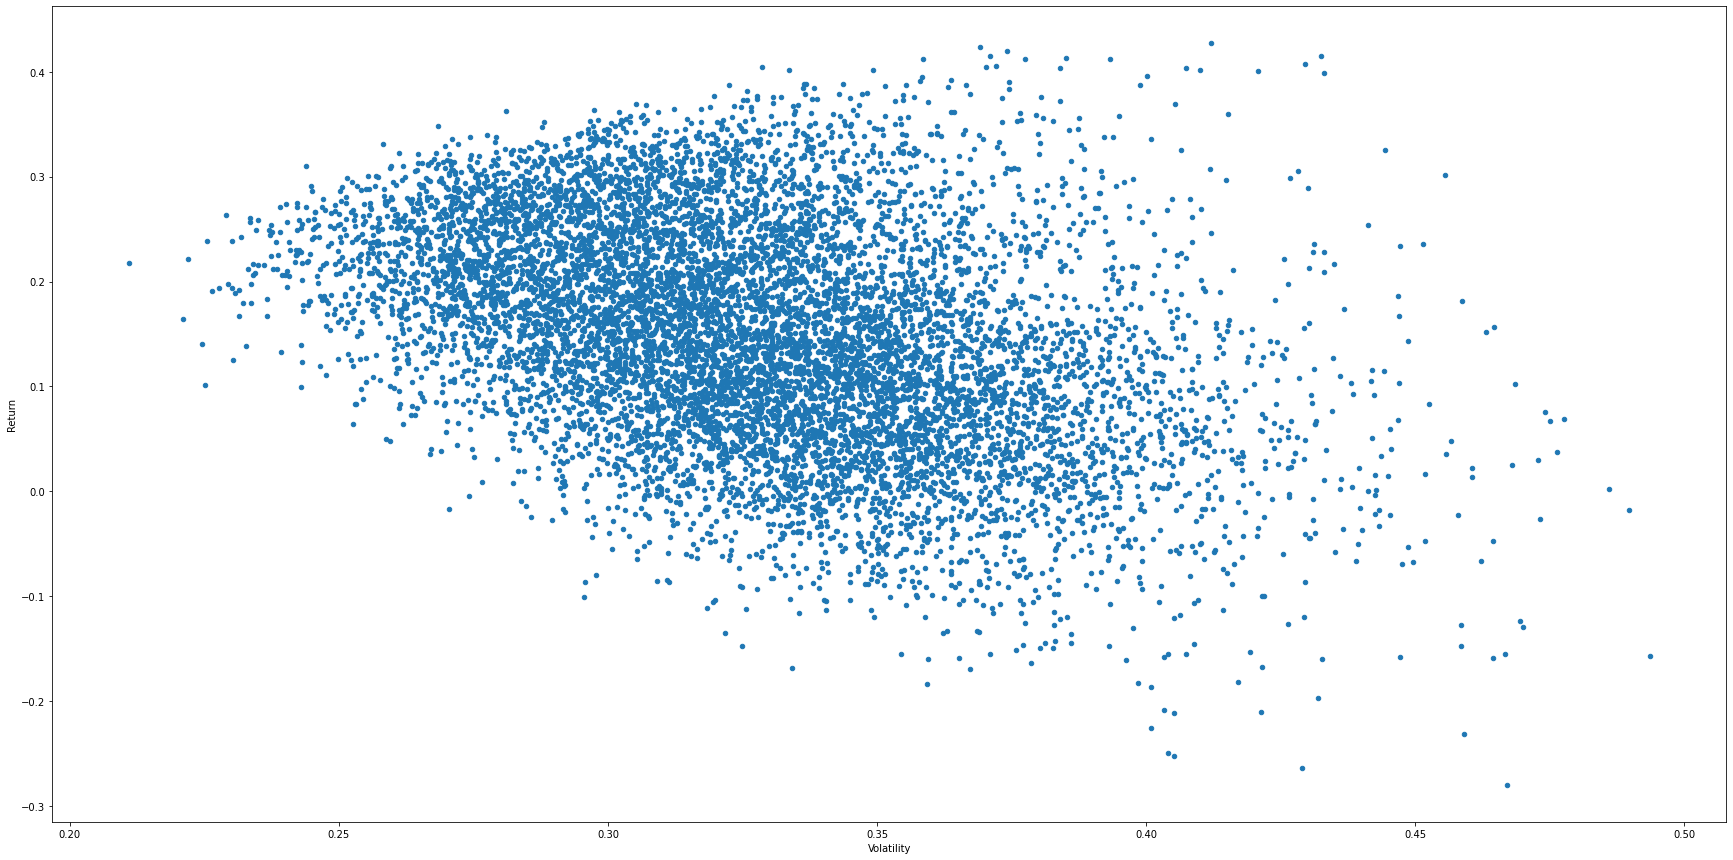

In [ ]:
ports = pd.DataFrame({'Return': p_ret, 'Volatility': p_vol})
print(ports)
ports.plot(x='Volatility', y='Return', kind='scatter', figsize=(30,15))

In [ ]:
#Sharp Ratio

SR_idx = np.argmax(p_SR)

i = 0

while i < num_stocks: 
  print('Stock : %s : %2.2f' % (port_list[i],
                                (p_wt[SR_idx][i] * 100)))
  i +=1

print('\nVolatility:', p_vol[SR_idx])
print("Return: ", p_ret[SR_idx])


# percetenage for the stock, for example, you will buy costco for 19.71%

Stock : AAPL : 17.78
Stock : NVDA : 15.30
Stock : TSLA : 17.17
Stock : FB : 1.65
Stock : TGT : 8.93
Stock : COST : 17.44
Stock : DIS : 13.54
Stock : VYGVF : 0.00
Stock : LCID : 6.52
Stock : CHPT : 1.67

Volatility: 0.268461461972489
Return:  0.34840040802620903


In [ ]:
def get_port_shares(one_price, force_one, wts, prices):
  num_stocks = len(wts)
  shares = []

  cost_shares = []

  i = 0
  while i < num_stocks: 
    max_price = one_price * wts[i]
    num_shares = int(max_price / prices[i])
    if(force_one & (num_shares == 0)):
      num_shares = 1
    shares.append(num_shares)
    cost = num_shares * prices[i]
    cost_shares.append(cost)
    i += 1
  return shares, cost_shares

In [ ]:
def get_port_weighting(share_cost):
    
    # Holds weights for stocks
    stock_wts = []
    # All values summed
    tot_val = sum(share_cost)
    print("Total Investment :", tot_val)
    
    for x in share_cost:
        stock_wts.append(x / tot_val)
    return stock_wts

In [ ]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Close',  date, 
                                  date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    return port_prices

In [ ]:
port_list = ['AAPL', 'NVDA', 'TSLA', 'FB', 'TGT', 'COST', 'DIS', 'VYGVF', 'LCID', 'CHPT']

port_wts = [18, 15, 17, 2, 9, 17, 14, 0, 7, 2]

# Get all stock prices on the starting date
port_df_start = merge_df_by_column_name('Close',  '2022-02-11', 
                                  '2022-02-11', *port_list)
# Convert from dataframe to Python list
port_prices = port_df_start.values.tolist()

# Trick that converts a list of lists into a single list
port_prices = sum(port_prices, [])

tot_shares, share_cost = get_port_shares(105.64, True, port_wts, port_prices)
print("Shares :", tot_shares)
print("Share Cost :", share_cost)

# Get list of weights for stocks
stock_wts = get_port_weighting(share_cost)
print("Stock Weights :", stock_wts)

# Get value at end of year
get_port_val_by_date(E_DATE, tot_shares, port_list)

Shares : [11, 6, 2, 1, 4, 3, 9, 1, 28, 15]
Share Cost : [1855.0399932861328, 1436.9400329589846, 1720.0, 219.5500030517578, 846.2399902343748, 1529.0100402832031, 1345.2300109863281, 8.3100004196167, 723.5200042724609, 202.5]
Total Investment : 9886.340075492859
Stock Weights : [0.18763667637577747, 0.14534600489022217, 0.17397742611178119, 0.022207409554522398, 0.0855968926592066, 0.15465885541136193, 0.13606956676728169, 0.000840553769763218, 0.07318380702541144, 0.020482807434671912]


[]